## Loading libraries

In [1]:
import os
from typing import Any, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from PIL import Image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATA_DIR = "faces/"
RANDOM_STATE = 12345
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

## Dataset

The dataset we will use for modeling is contained in `faces` folder. Let's take a closer look at what files it has.

In [2]:
data_path = os.path.join(os.getcwd(), "faces")
display(os.listdir(data_path))

['final_files', 'labels.csv']

The folder includes two elements:

* `final_files` => Folder containing images;
* `labels.csv` => File containing information on ages of people on photos.

### Images

Now, let's check what is contained in `final_files` folder. We will not print all its contents but will just include the first 10 items.

In [3]:
image_path = os.path.join(data_path, "final_files")
image_files = os.listdir(image_path)
display(image_files[:10])

['000000.jpg',
 '000001.jpg',
 '000002.jpg',
 '000003.jpg',
 '000004.jpg',
 '000005.jpg',
 '000006.jpg',
 '000007.jpg',
 '000008.jpg',
 '000009.jpg']

We see that this folder has a certain number of images in it. We printed only a part of this folder so let's look at how many images there are actually in the folder.

In [4]:
print(f"Folder contains {len(image_files):,} images.")

Folder contains 7,591 images.


### Labels

Now, we can take a look at what `labels.csv` looks like.

In [5]:
labels = pd.read_csv(DATA_DIR + "labels.csv")
display(labels.sample(10, random_state=RANDOM_STATE))

file_name  real_age
5370  005370.jpg        50
4516  004516.jpg        41
3968  003968.jpg        46
2188  002188.jpg        85
5833  005833.jpg        14
5521  005521.jpg        40
5393  005393.jpg        14
3913  003913.jpg        53
934   000934.jpg         4
6260  006264.jpg        32

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


We see that the number of entries in the DataFrame coincides with that of images found in `final_files` folder. There are no missing values. The table contains the following information:

<table>
<thead>
<tr><th style="text-align: center">Column</th><th style="text-align: center">Description</th></tr>
</thead>
<tbody>
    <tr><td style="text-align: center"><code>file_name</code></td><td style="text-align: center"><i>Name of a file in</i> <code>final_files</code> <i>folder</i></td></tr>
    <tr><td style="text-align: center"><code>real_age</code></td><td style="text-align: center"><i>Age of a person depicted on an image</i></td></tr>

</tbody>
</table>

The data we will be working with contains images of people's faces. Thus, in order to be able to train the model to accurately determine the age of a person on a photo, we will need some target variable. This information is exactly what is present in `labels` DataFrame.

**Summary**

At this stage, we have set up the environment that will be used for working with images as well as taken a look at what the dataset looks like. Basically, we have a folder with a little more than 7,500 images in it as well as a file containing links between a particular image and age of that person.

## Exploratory data analysis

### Image vizualizations

We can now get to exploring the images themselves and plot some images. For that, we can write a `show_image()` function that will either plot an image in accordance with the name of the file in `final_files` folder or return an array representation of that image.

In [7]:
def show_image(
    image_filename: str, age_data: pd.DataFrame, return_arr: bool = False
) -> Any:
    """
    Plots an image or returns numpy.ndarray representation
    of it.

    Args:
        image_filename: Name of a file.
        age_data: DataFrame containing information
            on image filenames and respective ages
            of people depicted on these photos.
        return_arr: Boolean indicating returning
            an array representation of an image.

    Returns:
        Any object.
    """
    image_path = DATA_DIR + "final_files/" + image_filename
    try:
        image = Image.open(image_path)
    except FileNotFoundError:
        print(f"File {image_filename} is not found.")
    else:
        # Recovering age associated with the image
        index = age_data[age_data["file_name"] == image_filename].index[0]
        age = age_data.loc[index]["real_age"]
        
        image_arr = np.array(image)
        
        # Return ndarray of the image
        if return_arr:
            return image_arr
        
        # Plotting a image
        plt.imshow(image_arr)
        plt.title(f"Age = {age}")
        plt.tight_layout()
        plt.show()

We can now use this function that will find in this case `006264.jpg` file and the respective age associated with this image in `labels` DataFrame. The result will be displayed.

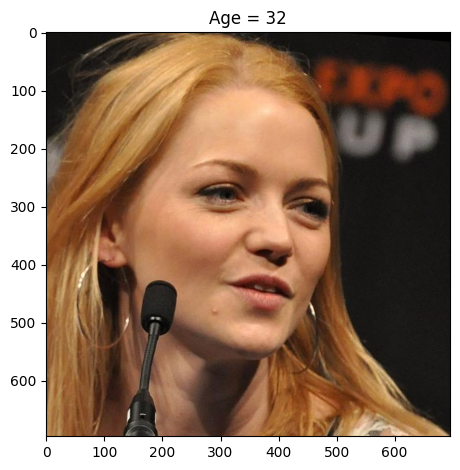

In [8]:
show_image(image_filename="006264.jpg", age_data=labels)

We can also look at this image from a different perspective and compute an array representation of this image.

In [9]:
image_6264_arr = show_image(
    image_filename="006264.jpg", age_data=labels, return_arr=True
)
print(f"Image dimensions: {image_6264_arr.shape}")

Image dimensions: (696, 696, 3)


We can see that we have an image with dimensions of `(696, 696, 3)`:

* Width => 696 (pixels)
* Height => 696 (pixels)
* Channels => 3 (RGB)

Let's take another picture.

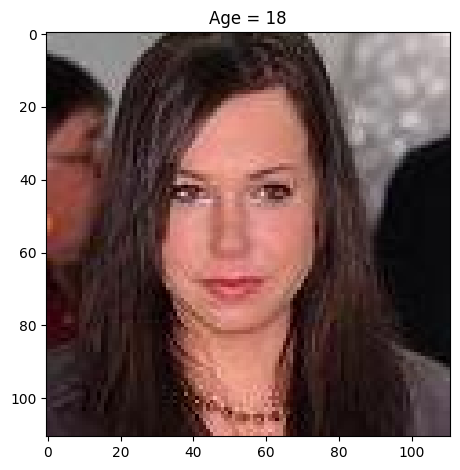

In [10]:
show_image(image_filename="000583.jpg", age_data=labels)

In [11]:
image_583_arr = show_image(
    image_filename="000583.jpg", age_data=labels, return_arr=True
)
print(f"Image dimensions: {image_583_arr.shape}")

Image dimensions: (111, 111, 3)


In this case we will have some other dimensions of the image. We need to actually have the images of the same dimensions that will be dealt with at a later stage.

### Ages distribution

Next, let's look at how ages of people are distributed in the data.

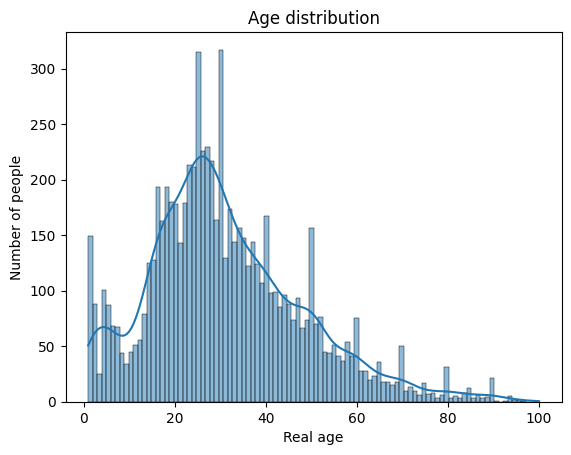

In [12]:
histplot = sns.histplot(labels["real_age"], bins=100, kde=True)
histplot.set(xlabel="Real age", ylabel="Number of people", title="Age distribution")
plt.show()

We can now see some peculiarities of the data. For instance, large number of objects is attributed to people with ages of 25-30-40-50 etc.

### Dividing into batches

Now, we can consider images further and for that we can divide the images in `final_files` folder into batches of 32 images each which will be transformed into those of `(224, 224, 3)` dimensions. Thanks to `flow_from_dataframe()` method from `keras` we can work with image file names from `labels` DataFrame.

This division will be done here solely for image display purposes. Actual division of the batches into training and validation sets will be carried out later.

In [13]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=DATA_DIR + "final_files/",
    x_col="file_name",
    y_col="real_age",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    seed=RANDOM_STATE,
)

Found 7591 validated image filenames.


Now, let's plot some number of images in some batch. For that, we create `plot_img_batch()` functions.

In [14]:
KerasIterator = type(datagen_flow)

In [15]:
def plot_img_batch(iterator: KerasIterator, img_layout: Tuple[int]) -> Any:
    """
    Plots a subset of images in a batch.
    
    Args:
        iterator: Iterator object storing images.
        img_layout: Tuple object storing the desired
            number of rows and columns to be used
            in the resulting subplot figure.
    
    Returns:
        Any object.
    """
    # Taking images and age in the next batch
    features, target = next(iterator)
    # Selecting number of rows and columns
    nrows, ncols = img_layout
    # Plotting a subset of images in a batch
    fig = plt.figure(figsize=(5 * ncols, 5 * nrows))
    print(f"Plotting {nrows * ncols}/{len(features)} images from a batch...\n")
    for i in range(nrows * ncols):
        fig.add_subplot(nrows, ncols, i + 1)
        plt.imshow(features[i])
        plt.title(f"Age = {target[i]}")
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

Plotting 12/32 images from a batch...



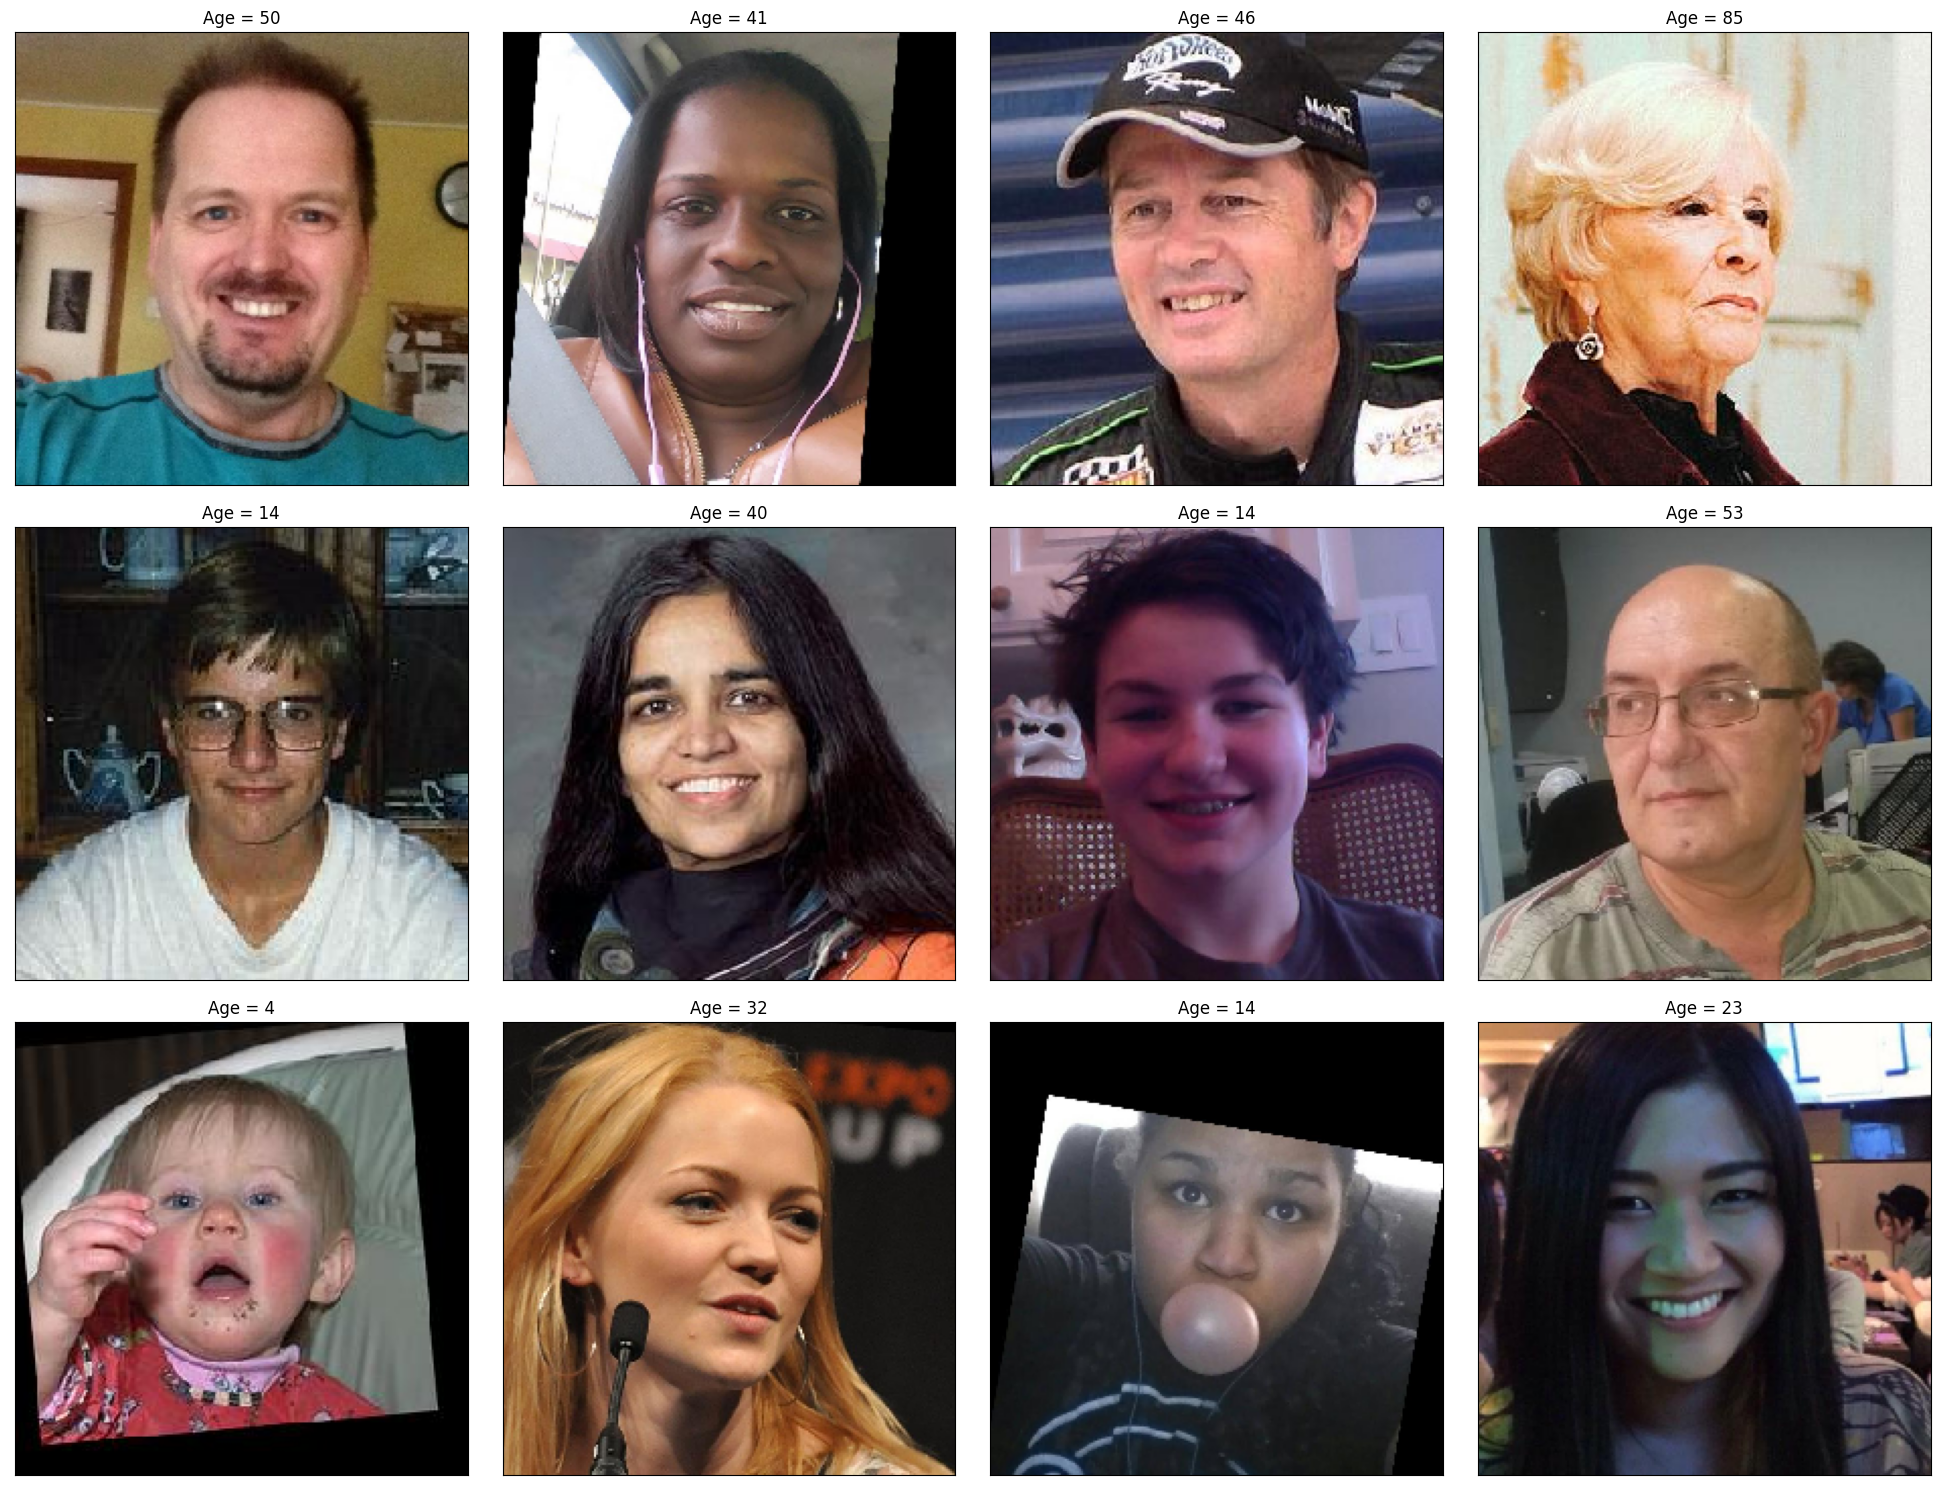

In [16]:
plot_img_batch(iterator=datagen_flow, img_layout=(3, 4))

For the subsample of images displayed above we can notice the following. Some photos appear to be somewhat shifted. In order to understand why this is the case, we need to understand how the data was actually collected.

Initially, a lot of very different photos from the Internet were collected (this explains the presence in the data of black-and-white photos, frames from movies and photos of celebrities). Then, using computer vision algorithms, the following operations were performed:
    
* Faces have been identified and cut from photos;
* The angle of deviation of the face from the vertical was found and an alignment attempt was made.
    
If we look at the data more closely, we can also find places where the algorithm did not manage to find a face. Besides, these shifted photos could also have appeared due to low-quality photos or where the algorithm was confused by extraneous signs - glasses, gum, etc.

## Training a neural net [GPU]

In this section, we will build a neural network in order to solve the problem. It would take a very long time to train such a model on *CPU* so we will make use of the *GPU* server provided by *Yandex Practicum* and will upload the code there. In order that everything would work, we will have to write the following functions:

* `load_train()` => Loading the training dataset;
* `load_test()` => Loading the dataset for validation;
* `create_model()` => Creating a model;
* `train_model()` => Model training.

These functions will be used in the code to be uploaded to the server and will not thus appear in this notebook, so we will simply describe here what these functions have inside.

### Importing libraries

In this block of code, we just import important data structures and libraries in order to work with neural nets. As can be seen, we will be using `tensorflow` for building and training the model.

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
```

### Loading training data

Here, we will load the data from the directory in accordance with file names in `labels.csv` and will divide it into training and validation sets. As seen on the images displayed above, the faces are not always located on one side of the photo and therefore we will boost learning capabilities of the neural net by including `horizontal_flip=True` as a data augmentation step. Additionally, we have seen that some photos appeared to be shifted which we can include in the data by shifting (rotating) images by some small angles done by `rotation_range=20`.

```python
def load_train(path):
    labels = pd.read_csv(path + "labels.csv")
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=20,
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + "final_files/",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        subset="training",
        class_mode="raw",
        seed=12345,
    )

    return train_datagen_flow
```

### Loading validation data

At this step, we do not do any data augmentations and simply specify `subset="validation"` for generating a validation set.

```python
def load_test(path):
    labels = pd.read_csv(path + "labels.csv")
    valid_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    valid_datagen_flow = valid_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + "final_files/",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        subset="validation",
        class_mode="raw",
        seed=12345,
    )

    return valid_datagen_flow
```

### Creating a neural net

We now get to building our model: 

1. Using tools from `tensorflow.keras` we will use `ResNet50` as a backbone to which we will add `GlobalAveragePooing2D` and a fully connected layer with one neuron and *ReLU* activation. 

2. When running the code on the *GPU* server, *ImageNET*-weights have already been uploaded and therefore we specify the path to these weights in `weights`. 

3. *MSE* will be used as a loss function and *MAE* - as a metric which we will monitor and be able to judge the quality of the model.

```python
def create_model(input_shape):

    optimizer = Adam(learning_rate=0.0001)

    backbone = ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights="/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5",
    )

    model = Sequential()

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation="relu"))

    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

    return model
```

Let's look at the architecture of the model.

In [17]:
def create_model(input_shape):

    optimizer = Adam(learning_rate=0.0001)

    backbone = ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet",
    )

    model = Sequential()

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation="relu"))

    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

    return model

In [18]:
model = create_model(input_shape=(224, 224, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


As described above, we use `resnet50` as a backbone with an output Tensor of dimensions `(7, 7, 2048)` which is then reduced to a layer with 2048 neurons and the output layer with 1 neuron. 

Let's now look more closely at what this backbone actually consists of.

In [19]:
resnet50_backbone = ResNet50(
    input_shape=(224, 224, 3), 
    include_top=False, 
    weights='imagenet'
    ) 
resnet50_backbone.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

We see that the backbone of the neural net consists of a wide range of different layers. This is *ResNet* architecture which makes use of *Shortcut Connections* (additional connections inside the network) in order to solve the problem of the *vanishing gradient* present in convolutional neural nets.

Interestingly, we see that some parameters of the backbone appear to be non-trainable. Let's try to understand where exactly it occurs.

In [20]:
for layer in resnet50_backbone.layers:
    if layer.non_trainable_weights:
        print(layer.name)

conv1_bn
conv2_block1_1_bn
conv2_block1_2_bn
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block2_1_bn
conv2_block2_2_bn
conv2_block2_3_bn
conv2_block3_1_bn
conv2_block3_2_bn
conv2_block3_3_bn
conv3_block1_1_bn
conv3_block1_2_bn
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block2_1_bn
conv3_block2_2_bn
conv3_block2_3_bn
conv3_block3_1_bn
conv3_block3_2_bn
conv3_block3_3_bn
conv3_block4_1_bn
conv3_block4_2_bn
conv3_block4_3_bn
conv4_block1_1_bn
conv4_block1_2_bn
conv4_block1_0_bn
conv4_block1_3_bn
conv4_block2_1_bn
conv4_block2_2_bn
conv4_block2_3_bn
conv4_block3_1_bn
conv4_block3_2_bn
conv4_block3_3_bn
conv4_block4_1_bn
conv4_block4_2_bn
conv4_block4_3_bn
conv4_block5_1_bn
conv4_block5_2_bn
conv4_block5_3_bn
conv4_block6_1_bn
conv4_block6_2_bn
conv4_block6_3_bn
conv5_block1_1_bn
conv5_block1_2_bn
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block2_1_bn
conv5_block2_2_bn
conv5_block2_3_bn
conv5_block3_1_bn
conv5_block3_2_bn
conv5_block3_3_bn


It turns out that these non-trainable weights are present in `BatchNormalization` layers which helps the model to learn better as well as combats overfitting. Let's take the weights of the first `conv1_bn` layer for example.

In [21]:
for layer in resnet50_backbone.layers:
    if layer.non_trainable_weights:
        break

layer.non_trainable_weights

[<tf.Variable 'conv1_bn/moving_mean:0' shape=(64,) dtype=float32, numpy=
 array([-0.1512462 , -0.64193594, -0.5950486 ,  0.5573925 ,  0.04964633,
        -1.3543581 , -0.55720747,  0.7028118 ,  0.72205496, -0.06209099,
         0.12961772,  0.04776215,  0.00559795, -1.2660099 ,  0.33788112,
         0.56091577, -0.64116454, -0.07362732, -0.24347433,  0.08685432,
        -0.10537097,  0.09455026, -2.3035636 ,  0.009311  , -0.07884994,
        -0.09572847,  1.5617214 , -0.159881  ,  0.11597473,  0.7430062 ,
         0.46179256, -0.17867799,  0.19140534, -0.05171439,  2.7138855 ,
         0.12593503, -0.25815797,  0.1700401 ,  3.334259  , -1.4724497 ,
         0.36282057,  0.05076902, -0.14957784,  0.31851518,  0.05544581,
         2.1343627 , -0.00823953, -0.4773408 , -0.45457822, -0.07698756,
         2.9924777 ,  0.7342864 ,  0.11639247, -0.20091796, -0.6945088 ,
         0.05711879, -0.49359688, -0.25796604, -0.26115438,  0.05262396,
         0.21160594, -0.27037546, -3.5374024 , -0.0

We see that we have two types of weights in this layer:

* `moving_mean`
* `moving_variance`

These are used for normalization and are actually updated not in the process of backpropagation but during going through this layer directly. Hence, these are not trainable.

### Training the model

We also include the code for training the model with 15 epochs. Additionally, we and `steps_per_epoch=178` and `validation_steps=60`. These particular numbers are basically the dimensions of the iterators returned by `load_train()` and `load_test()`. In other words, these are the numbers of batches of 32 objects we managed to divide our data into.

```python
def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=15,
    steps_per_epoch=178,
    validation_steps=60,
):
    model.fit(
        train_data,
        validation_data=test_data,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
    )

    return model
```

**Summary**

This section was devoted to describing the code to be uploaded to the *GPU* server. We have described what each function written above is responsible for as well as discussed the features of *ResNet* architecture.

## Analyzing the trained model

### Training results

After training the neural net on the data with images and people ages, the server provided us with the following output information.

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/15
178/178 - 163s - loss: 369.0117 - mae: 13.6411 - val_loss: 758.3526 - val_mae: 22.6052
Epoch 2/15
178/178 - 88s - loss: 95.5556 - mae: 7.3557 - val_loss: 651.5985 - val_mae: 20.5299
Epoch 3/15
178/178 - 89s - loss: 73.4302 - mae: 6.5044 - val_loss: 278.8198 - val_mae: 12.4315
Epoch 4/15
178/178 - 89s - loss: 59.6063 - mae: 5.8894 - val_loss: 128.1395 - val_mae: 8.6386
Epoch 5/15
178/178 - 89s - loss: 48.7186 - mae: 5.3032 - val_loss: 97.2150 - val_mae: 7.2674
Epoch 6/15
178/178 - 89s - loss: 42.0724 - mae: 4.9485 - val_loss: 68.3706 - val_mae: 6.1833
Epoch 7/15
178/178 - 88s - loss: 35.1015 - mae: 4.5717 - val_loss: 92.6888 - val_mae: 6.8942
Epoch 8/15
178/178 - 89s - loss: 28.9411 - mae: 4.0996 - val_loss: 252.0258 - val_mae: 13.3325
Epoch 9/15
178/178 - 89s - loss: 27.4737 - mae: 3.9905 - val_loss: 71.1416 - val_mae: 6.1396
Epoch 10/15
178/178 - 93s - loss: 22.0646 - mae: 3.6166 - val_loss: 66.8197 - val_mae: 5.9738
Epoch 11/15
178/178 - 94s - loss: 20.4153 - mae: 3.4977 - val_loss: 66.5659 - val_mae: 6.1035
Epoch 12/15
178/178 - 92s - loss: 19.0759 - mae: 3.3728 - val_loss: 59.9269 - val_mae: 5.8234
Epoch 13/15
178/178 - 94s - loss: 17.1425 - mae: 3.1842 - val_loss: 77.0378 - val_mae: 6.7801
Epoch 14/15
178/178 - 92s - loss: 15.2801 - mae: 3.0235 - val_loss: 63.5203 - val_mae: 5.7894
Epoch 15/15
178/178 - 92s - loss: 12.8564 - mae: 2.7582 - val_loss: 62.1058 - val_mae: 5.7644

60/60 - 10s - loss: 62.1058 - mae: 5.7644
Test MAE: 5.7644
```

We see that as we go from one epoch to the next, the quality metric (in this case, *Mean Squared Error*) gets better and better. After epoch 9, we eventually reach a plateau on the metric and on the last epoch we obtain the value of about 5.76.

### Trained model

<table>
<thead>
<tr><th style="text-align: center">Characteristic</th><th style="text-align: center">Description</th></tr>
</thead>
<tbody>
    <tr><td style="text-align: center">Backbone</td><td style="text-align: center"><i>ResNet50</i></td></tr>
    <tr><td style="text-align: center">Top</td><td style="text-align: center"><i>Glob Avg Pull + FC 1</i></td></tr>
    <tr><td style="text-align: center">Initial weights</td><td style="text-align: center"><i>ImageNet-pretrained</i></td></tr>
    <tr><td style="text-align: center">Batch size</td><td style="text-align: center"><i>32</i></td></tr>
    <tr><td style="text-align: center">Optimizer</td><td style="text-align: center"><i>Adam(0.0001)</i></td></tr>
    <tr><td style="text-align: center">Backbone weights freeze</td><td style="text-align: center"><i>No</i></td></tr>
    <tr><td style="text-align: center">Epochs</td><td style="text-align: center"><i>15</i></td></tr>
</tbody>
</table>

### Attained metrics

<table>
<thead>
<tr><th style="text-align: center">Metric</th><th style="text-align: center">Subset</th><th style="text-align: center">Value</th></tr>
</thead>
<tbody>
    <tr><td style="text-align: center">MAE</td><td style="text-align: center"><i>Training</i></td><td style="text-align: center"><i>2.75</i></td></tr>
    <tr><td style="text-align: center">MAE</td><td style="text-align: center"><i>Validation</i></td><td style="text-align: center"><i>5.76</i></td></tr>

</tbody>
</table>

## General conclusion

In this study, we analyzed images of different people whose photos were marked up by age. After conducting an exploratory data analysis of the data, according to the results of which we were able to study the photos more closely, we wrote a code that, after execution on a separate *GPU* server, showcased appropriate learning indicators. The `ResNet` architecture model, fine-tuned to the needs of the study, solved the regression problem well and, according to the results, the model is wrong about people's ages within an average of 5.8 years.